# Taxi
https://www.gymlibrary.dev/environments/toy_text/taxi/

![Taxi](https://www.gymlibrary.dev/_images/taxi.gif)


In [56]:
# environment 
import gym  
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

## Environment Recognition

In [57]:
# if you want to output text directly to the terminal, you should add render_mode='ansi'.
env = gym.make("Taxi-v3",render_mode='ansi')

# Ortamı başlangıç durumuna döndürür.
env.reset()

# Mevcut ortamı görselleştirme
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [58]:
print("Observation Space:", env.observation_space.n)
print("Action Space:", env.action_space.n)

Observation Space: 500
Action Space: 6


**500 farklı durum ve 6 farklı aksiyon**

In [59]:
# q-table initalize
qtable = np.zeros((env.observation_space.n,env.action_space.n))# 500x6
qtable.shape

(500, 6)

In [60]:
qtable[:10] # Left Down Right Up Pickup Dropoff

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

* 6 sütun: 6 farklı aksiyon (["south", "north", "east", "west", "pickup", "dropoff"])

In [61]:
print("Örnek Gözlem:", env.observation_space.sample())

Örnek Gözlem: 161


In [62]:
print("Örnek Aksiyon:", env.action_space.sample())

Örnek Aksiyon: 3


In [63]:
print(env.spec)

EnvSpec(id='Taxi-v3', entry_point='gym.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'ansi'}, namespace=None, name='Taxi', version=3)


**Observations**

* **25 (5x5) farklı taksi konumu x 5 farklı yolcu pozisyonu x 4 farklı varış noktası = 500 durum**

**Her bir durum, taksinin konumu, yolcunun pozisyonu ve varış noktasına göre belirlenen bir kombinasyondur.**

- Passenger locations:  0: R(ed) , 1: G(reen) , 2: Y(ellow) , 3: B(lue) , 4: in taxi

- Destinations: 0: R(ed) , 1: G(reen) , 2: Y(ellow) , 3: B(lue)

**Actions**

* 0: move south (güney) , 1: move north (kuzey) , 2: move east (doğu) , 3: move west (batı) ,
4: pickup passenger (yolcu al) , 5: drop off passenger (yolcu bırak)**


**Rewards**
* -1 : Her adımda -1 puan (diğer reward lar gerçekleşmediğinde) (gereksiz hareketleri engellemek için )

* +20 : Yolcuyu başarıyla bırakınca +20 puan

* -10 : Yanlış "biniş" veya "iniş" hareketinde -10 puan


## Q-learning

Q-learning, takviyeli öğrenme (Reinforcement Learning) algoritmasıdır ve bir ajanı, ödülleri en üst düzeye çıkaracak şekilde optimal bir yöntem öğrenmeyi amaçlar.

* 1 - Ajan, bir durum (state) içinde belirli bir eylem (action) seçer,
* 2- Ardından bir ödül (reward) alır ve bir sonraki duruma (next state) geçer. 
* 3- Q-table öğrenilen bilgiye göre güncellenir.
* 4- Ajan, öğrenme süreci boyunca farklı yollar dener ve en iyi stratejiyi bulur.
* 5- Episode tamamlandığında, ajan bir sonraki episode’a başlar ve zamanla Q-table’daki değerler en iyi hareketleri gösterecek şekilde güncellenir.
* Q-table, her durum için en iyi eylemleri içeren bir harita (matris) haline gelir. 

In [115]:
env = gym.make("Taxi-v3",render_mode='ansi')
env.reset()
# q-table initalize
qtable = np.zeros((env.observation_space.n,env.action_space.n))# 500x6

In [116]:
# Q-Learning hiperparametre
episodes = 500 
alpha = 0.4  # (Learning Rate)
gamma = 0.9  # (γ) - Discount Factor ; Gelecekteki ödüllerin (rewards) önem değeri
# 0.9 için ; Taksi, hemen ödül almak yerine yolcuyu doğru yere bırakmayı öncelikli hale getirir.
epsilon = 0.4 # Keşif Oranı (rastgele hareket)

**=> Çok fazla rastgele hareket büyük ceza getirir. Gereksiz hareketlerden kaçınmalıyız.**

Q-learning **"off-policy"** bir yöntemdir, yani ajan şu anki stratejisinden bağımsız olarak **gelecekteki en iyi hareketi** öğrenmeye çalışır.

In [117]:
reward_history = [] 
epsilon_history = []
#  Training
for _ in range(episodes):
    current_state,_ = env.reset() # agentın bulunduğu state değerini al
    done = False 
    
    while not done:

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()# Keşif (exploration) 
        else:
            action = np.argmax(qtable[current_state])# Q-table daki en iyi aksiyonu seç (exploitation)  
            
        next_state, reward, done, truncated, _ = env.step(action)
        
        # q-table updating 
        # Yeni öğrenilen değer : (reward + gamma * max(qtable[next_state]))
        qtable[current_state,action] += alpha*(reward+gamma*np.max(qtable[next_state]) - qtable[current_state,action])
        
        # update state
        current_state = next_state  # Update current state

        reward_history.append(reward)

    epsilon_history.append(epsilon)
    epsilon = max(0.01, epsilon * 0.997) 


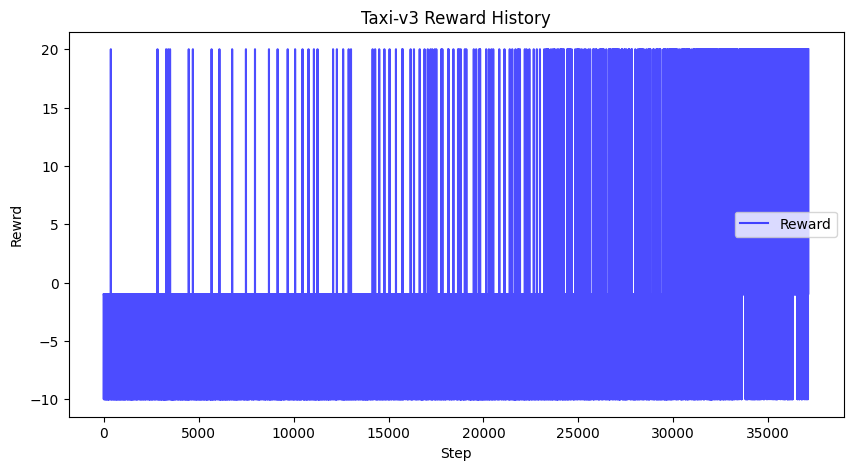

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(reward_history, label="Reward", color="blue", alpha=0.7)
plt.xlabel("Step")
plt.ylabel("Rewrd")
plt.title("Taxi-v3 Reward History")
plt.legend()
plt.show()

In [119]:
reward_df = pd.DataFrame({'Reward': reward_history})

reward_counts = reward_df['Reward'].value_counts().reset_index()
reward_counts.columns = ['Reward', 'Count']

reward_counts

,Reward,Count
0,-1,32348
1,-10,4266
2,20,500


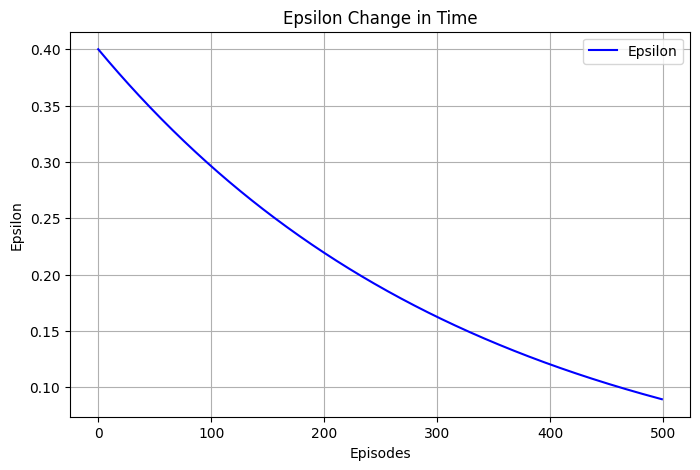

In [120]:
plt.figure(figsize=(8, 5))
plt.plot(range(episodes), epsilon_history, color='blue', label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Change in Time')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
qtable[:10]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -5.03300867,  -2.51128196,  -4.7988665 ,  -3.16177916,
          1.62260712, -11.82508127],
       [ -1.51430963,   0.93695582,  -2.45312077,   2.59492725,
          7.71469662,  -5.09343521],
       [ -4.19824614,  -0.71274058,  -4.02182269,  -3.80356896,
          2.91399633,  -9.20763572],
       [ -5.95553969,  -6.00497467,  -5.97074223,  -5.92518689,
        -13.08115925, -12.35769524],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -6.52803418,  -6.54660401,  -6.44562861,  -6.54019152,
         -7.29478908, -12.07827848],
       [ -5.09184772,  -4.92101229,  -4.97754901,  -5.09725142,
        -12.61312421, -11.36718827],
       [ -1.82766139,  -4.59490167,  -4.50169914,  -4.49798607,
        -12.46159329, -13.22375932],
       [ -4.81128746,  -6.05375357,  -6.06361991,  -6.02644829,
        -13.11620926, -12.7

In [130]:
env.reset()

(52, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})

## Evaluation (Sonuçları Değerlendirme)

✅ Öğrenilen Q-tablosunu kullanarak ajanı rastgele keşif yapmadan ajanı test edelim.
Rastgelelik olmadan **(ε = 0)** ile q-table da dolaşalım.

In [131]:
test_episodes = 100
MAX_STEPS = 200

total_penalties = [] 
total_steps = [] 
successful_dropoffs = 0

for episode in range(test_episodes):
    state, _ = env.reset()
    done = False
    episode_penalties = 0    
    episode_steps = 0

    while not done and episode_steps < MAX_STEPS:
        action = np.argmax(qtable[state])  
        next_state, reward, done, _, _ = env.step(action)
        
        episode_penalties += reward
        episode_steps += 1 
        state = next_state
        
        if reward == 20:
            successful_dropoffs += 1
        
    total_penalties.append(episode_penalties) 
    total_steps.append(episode_steps) 
    print(f"Episode {episode+1} finished in {episode_steps} steps")

avg_steps = np.mean(total_steps)
avg_penalties = sum(total_penalties) / test_episodes
success_rate = successful_dropoffs / test_episodes * 100

Episode 1 finished in 8 steps
Episode 2 finished in 200 steps
Episode 3 finished in 12 steps
Episode 4 finished in 11 steps
Episode 5 finished in 9 steps
Episode 6 finished in 12 steps
Episode 7 finished in 16 steps
Episode 8 finished in 13 steps
Episode 9 finished in 14 steps
Episode 10 finished in 200 steps
Episode 11 finished in 10 steps
Episode 12 finished in 200 steps
Episode 13 finished in 8 steps
Episode 14 finished in 11 steps
Episode 15 finished in 14 steps
Episode 16 finished in 14 steps
Episode 17 finished in 14 steps
Episode 18 finished in 200 steps
Episode 19 finished in 200 steps
Episode 20 finished in 8 steps
Episode 21 finished in 200 steps
Episode 22 finished in 10 steps
Episode 23 finished in 13 steps
Episode 24 finished in 13 steps
Episode 25 finished in 200 steps
Episode 26 finished in 16 steps
Episode 27 finished in 10 steps
Episode 28 finished in 15 steps
Episode 29 finished in 14 steps
Episode 30 finished in 13 steps
Episode 31 finished in 14 steps
Episode 32 fin

In [132]:
print(f"\n✅ Average steps per episode: {avg_steps:.2f}")
print(f"✅ Average penalty per episode: {avg_penalties:.2f}")
print(f"✅ Success rate: {success_rate:.2f}%")


✅ Average steps per episode: 53.52
✅ Average penalty per episode: -37.14
✅ Success rate: 78.00%


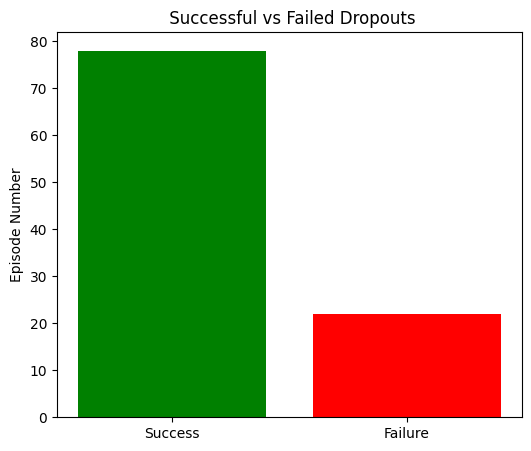

In [133]:
labels = ['Success', 'Failure']
values = [successful_dropoffs, test_episodes - successful_dropoffs]

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=['green', 'red'])
plt.title(' Successful vs Failed Dropouts')
plt.ylabel('Episode Number')
plt.show()